In [2]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
from torch.autograd import Variable
import numpy as np
from torch.utils.data import TensorDataset, DataLoader
from math import isclose

%pylab inline
from matplotlib import cm
from IPython.display import HTML
_SAVE_GIFS= False
rcParams.update({'axes.labelsize': 17.,
              'font.size': 12.,
              'legend.fontsize': 17.,
              'xtick.labelsize':15.,
              'ytick.labelsize':15.,
              'text.usetex': _SAVE_GIFS,
              'figure.figsize': [10,10],
              'xtick.major.size' : 4,
              'ytick.major.size' : 4,
              'xtick.minor.size' : 2,
              'ytick.minor.size' : 2,
              'legend.numpoints':1})

Populating the interactive namespace from numpy and matplotlib


In [3]:
# '''
# CREATE SAMPLE DATASETS
# '''
# sample_size = 1000

# train_array = np.empty((2, sample_size, 10))
# train_array[0, :, :] = np.random.rand(1, sample_size, 10)
# # train_array[0, :, :] = (train_array[0, :, :] - np.mean(train_array[0, :, :]))/np.std(train_array[0, :, :])
# train_array[1, :, :] = train_array[0, :, :]
# print(train_array[0,0,4], train_array[1,0,4])

# test_array = np.empty((2, sample_size, 10))
# test_array[0, :, :] = np.random.rand(1, sample_size, 10)
# # test_array[0, :, :] = (test_array[0, :, :] - np.mean(test_array[0, :, :]))/np.std(train_array[0, :, :])
# test_array[1, :, :] = test_array[0, :, :]



In [37]:
'''
STEP 1: LOADING DATASET
'''
N = 1001
weights=1
xv = 0
x_min = -8.
x_max = 8.
x_range = x_max - x_min
v_min = -8.
v_max = 8.
v_range = v_max - v_min


train_array = np.load('varpert_sech2_rho_train_2000.npy')

mean = train_array[0, xv, :, :-1].mean(axis=1)
mean_sub = np.transpose(train_array[0, xv, ...]) - 0
var = train_array[0, xv, :, :].std(axis=1)
train_array[0, xv, :, :] = np.transpose(mean_sub/   var    )

mean = train_array[1, xv, :, :].mean(axis=1)
mean_sub = np.transpose(train_array[1, xv, ...]) - 0
var = train_array[1, xv, :, :].std(axis=1)
train_array[1, xv, :, :] = np.transpose(mean_sub/   var    )

train_tensor = torch.Tensor(train_array)
train_dataset = TensorDataset(train_tensor[0, xv, :, :], train_tensor[1, xv, :, :]) # create your datset



test_array = np.load('varpert_sech2_rho_test_500.npy')

mean = test_array[0, xv, :, :].mean(axis=1)
mean_sub = np.transpose(test_array[0, xv, ...]) - 0
var = test_array[0, xv, :, :].std(axis=1)
test_array[0, xv, :, :] = np.transpose(mean_sub/   var    )

mean = test_array[1, xv, :, :].mean(axis=1)
mean_sub = np.transpose(test_array[1, xv, ...]) - 0
var = test_array[1, xv, :, :].std(axis=1)
test_array[1, xv, :, :] = np.transpose(mean_sub/   var    )

test_tensor = torch.Tensor(test_array)*weights
test_dataset = TensorDataset(test_tensor[0, xv, :, :], test_tensor[1, xv, :, :]) # create your datset



# deg_freedom = train_tensor[:, xv, 0, 0].size()[0]
train_size = train_tensor[0, xv, :, 0].size()[0]
test_size = test_tensor[0, xv, :, 0].size()[0]
num_datapoints = train_tensor[0, xv, 0, :].size()[0]

print(train_size, test_size, num_datapoints)
print(train_array[0, xv, 1000, :])

2000 500 50
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.02591422 0.02591422 0.07774266 0.1295711  0.02591422 0.18139953
 0.25914219 0.62194126 1.03656876 2.04722331 2.15088019 3.00604942
 3.91304709 3.3947627  2.82464988 2.22862284 1.65851002 0.93291189
 0.6737697  0.36279907 0.10365688 0.07774266 0.10365688 0.
 0.02591422 0.02591422 0.         0.         0.02591422 0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]


Text(0, 0.5, '$\\rho(x)$')

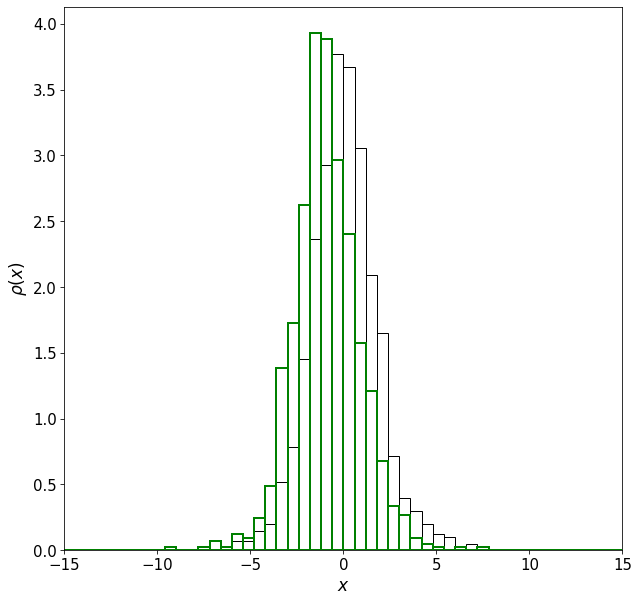

In [38]:
width = x_range/num_datapoints

bins = np.linspace(x_min, x_max, num=num_datapoints, endpoint=False)
npinputs = np.transpose( np.transpose(train_array[0, xv, :, :]) + np.abs(np.amin(train_array[0, xv, :, :], axis=1)) )
npoutputs = np.transpose( np.transpose(train_array[1, xv, :, :]) + np.abs(np.amin(train_array[1, xv, :, :], axis=1)) )

fig, ax= subplots()

ax.bar(bins, npinputs[500, :], width=width, lw=1., ec='k', fill=False, align='edge')
ax.bar(bins, npoutputs[500, :], width=width, lw=2., ec='g', fill=False, align='edge')
ax.set_xlim(x_min, x_max)
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$\rho(x)$')
# ax.set_yscale('log')

In [39]:
'''
STEP 2: MAKING DATASET ITERABLE
'''

batch_size = 100
num_batches = len(train_dataset)/batch_size
print(num_batches)

n_iters = 40000

num_epochs = n_iters / num_batches
print(num_epochs)
num_epochs = int(num_epochs)

train_loader = DataLoader(dataset=train_dataset, 
                            batch_size=batch_size, 
                            shuffle=True)

test_loader = DataLoader(dataset=test_dataset, 
                            batch_size=batch_size, 
                            shuffle=False)

20.0
2000.0


In [40]:
'''
STEP 3: CREATE MODEL CLASS
'''
class FeedforwardNeuralNetModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(FeedforwardNeuralNetModel, self).__init__()
        # Linear function 1: 784 --> 100
        self.fc1 = nn.Linear(input_dim, hidden_dim) 
        # Non-linearity 1
        self.relu1 = nn.Tanh()
        
        # Linear function 2: 100 --> 100
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        # Non-linearity 2
        self.relu2 = nn.Tanh()

        # Linear function 3: 100 --> 100
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        # Non-linearity 3
        self.relu3 = nn.Tanh()

        # Linear function 4: 100 --> 100
        self.fc4 = nn.Linear(hidden_dim, hidden_dim)
        # Non-linearity 4
        self.relu4 = nn.Tanh()
        
        # Linear function 5 (readout): 100 --> 10
        self.fc5 = nn.Linear(hidden_dim, output_dim)  
    
    def forward(self, x):
        # Linear function 1
        out = self.fc1(x)
        # Non-linearity 1
        out = self.relu1(out)
        
        # Linear function 2
        out = self.fc2(out)
        # Non-linearity 2
        out = self.relu2(out)
        
        # Linear function 3
        out = self.fc3(out)
        # Non-linearity 3
        out = self.relu3(out)

        # Linear function 4
        out = self.fc4(out)
        # Non-linearity 4
        out = self.relu4(out)
        
        # Linear function 5 (readout)
        out = self.fc5(out)

        return out

In [41]:
'''
STEP 4: INSTANTIATE MODEL CLASS
'''
input_dim = num_datapoints
hidden_dim = input_dim*5
output_dim = input_dim
print(input_dim, hidden_dim, output_dim)

model = FeedforwardNeuralNetModel(input_dim, hidden_dim, output_dim)

50 250 50


In [42]:
'''
STEP 5: INSTANTIATE LOSS CLASS
'''
criterion = nn.MSELoss()

In [43]:
'''
STEP 6: INSTANTIATE OPTIMIZER CLASS
'''
learning_rate = 0.2

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [44]:
'''
STEP 7: TRAIN THE MODEL
'''
iter = 0
train_predictions = np.empty((2, output_dim))
# all_true_outputs = np.empty((0, output_dim))
# all_model_outputs = np.empty((0, output_dim))

for epoch in range(num_epochs):
    # print("Epoch:", epoch)
    for i, (inputs, true_outputs) in enumerate(train_loader):
        # print("i:", i)

        inputs = Variable(inputs)
        true_outputs = Variable(true_outputs)
        
        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()
        
        # Forward pass to get output/logits
        model_outputs = model(inputs)
        
        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(model_outputs, true_outputs)
        
        # Getting gradients w.r.t. parameters
        loss.backward()
        
        # Updating parameters
        optimizer.step()
        
        iter += 1
        
        if iter % 5000 == 0:


            # Calculate Train Accuracy         
            correct = 0
            total = 0
            # Iterate through train dataset
            for inputs, true_outputs in train_loader:
                inputs = Variable(inputs)

                # Forward pass only to get logits/output
                model_outputs = model(inputs)

                # Total number of true_outputs
                total += true_outputs.nelement()

                nppredicted = model_outputs.detach().numpy()
                nptrue = true_outputs.numpy()
                size = np.size(nptrue, 0)

                for j in range(size):
                    predicted = nppredicted[j,:]
                    true = nptrue[j,:]

                    # Total correct predictions
                    correct += (np.isclose(predicted, true, rtol=0.1)).sum()
            
            train_predictions[0, :] = true
            train_predictions[1, :] = predicted

            train_accuracy = 100 * correct / total




            # Calculate Test Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for inputs, true_outputs in test_loader:
                inputs = Variable(inputs)

                # Forward pass only to get logits/output
                model_outputs = model(inputs)

                # Total number of true_outputs
                total += true_outputs.nelement()

                nppredicted = model_outputs.detach().numpy()
                nptrue = true_outputs.numpy()
                size = np.size(nptrue, 0)

                for j in range(size):
                    predicted = nppredicted[j,:]
                    true = nptrue[j,:]

                    # Total correct predictions
                    correct += (np.isclose(predicted, true, rtol=0.1)).sum()
            
            test_accuracy = 100 * correct / total




            # Print Loss
            print('Iteration: {}. Loss: {}. Train Accuracy: {}. Test Accuracy: {}'.format(iter, loss.data, train_accuracy, test_accuracy))

Iteration: 5000. Loss: 0.010702081024646759. Train Accuracy: 18.158. Test Accuracy: 17.936
Iteration: 10000. Loss: 0.00837326142936945. Train Accuracy: 19.049. Test Accuracy: 18.456
Iteration: 15000. Loss: 0.00938824936747551. Train Accuracy: 19.478. Test Accuracy: 18.736
Iteration: 20000. Loss: 0.008603026159107685. Train Accuracy: 19.618. Test Accuracy: 18.928
Iteration: 25000. Loss: 0.008081424981355667. Train Accuracy: 19.856. Test Accuracy: 19.124
Iteration: 30000. Loss: 0.008612277917563915. Train Accuracy: 19.738. Test Accuracy: 19.14
Iteration: 35000. Loss: 0.0081876739859581. Train Accuracy: 19.709. Test Accuracy: 19.06
Iteration: 40000. Loss: 0.008215529844164848. Train Accuracy: 19.645. Test Accuracy: 19.132


In [45]:
npinputs = inputs.detach().numpy()
npoutputs = model_outputs.detach().numpy()
nptargets = true_outputs.detach().numpy()
print(npinputs.shape)
print(npoutputs.shape)
print(nptargets.shape)

# npoutputs = np.transpose( np.transpose(npoutputs) + np.abs(np.amin(npoutputs, axis=1)) )
# nptargets = np.transpose( np.transpose(nptargets) + np.abs(np.amin(nptargets, axis=1)) )
# print(npoutputs.shape)
# print(nptargets.shape)

(100, 50)
(100, 50)
(100, 50)


Text(0, 0.5, '$\\rho(x)$')

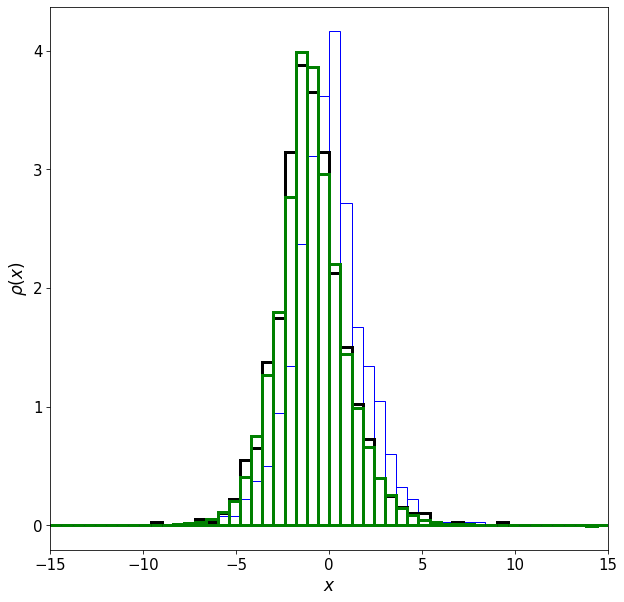

In [46]:
fig, ax= subplots()

ax.bar(bins, npinputs[0, :], width=width, lw=1., ec='b', fill=False, align='edge')
ax.bar(bins, nptargets[0, :], width=width, lw=3., ec='k', fill=False, align='edge')
ax.bar(bins, npoutputs[0, :], width=width, lw=3., ec='g', fill=False, align='edge')
ax.set_xlim(x_min, x_max)
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$\rho(x)$')
# ax.set_yscale('log')

In [47]:
input_array = np.empty((0, input_dim))
output_array = np.empty((0, output_dim))
target_array = np.empty((0, output_dim))
# Iterate through test dataset
for inputs, true_outputs in test_loader:
    inputs = Variable(inputs)
    
    # Forward pass only to get logits/output
    model_outputs = model(inputs)

    loss = criterion(model_outputs, true_outputs)
    
    npinputs = inputs.detach().numpy()
    input_array = np.concatenate((input_array, npinputs))

    npoutputs = model_outputs.detach().numpy()
    output_array = np.concatenate((output_array, npoutputs))

    nptargets = true_outputs.detach().numpy()
    target_array = np.concatenate((target_array, nptargets))




output_array_flt = output_array.flatten()
target_array_flt  = target_array.flatten()

rel_err = np.empty(test_size)

for i in range(test_size):
    if target_array_flt[i]==0 and output_array_flt[i]!=0:
        rel_err[i] = np.abs(output_array_flt[i]-target_array_flt[i])/(output_array_flt[i])
    elif output_array_flt[i]==0 and target_array_flt[i]==0:
        rel_err[i] = 0
    else:
        rel_err[i] = np.abs(output_array_flt[i]-target_array_flt[i])/(target_array_flt[i])

rel_err.mean()*100

33.23342603495154

Text(0, 0.5, '$\\rho(x)$')

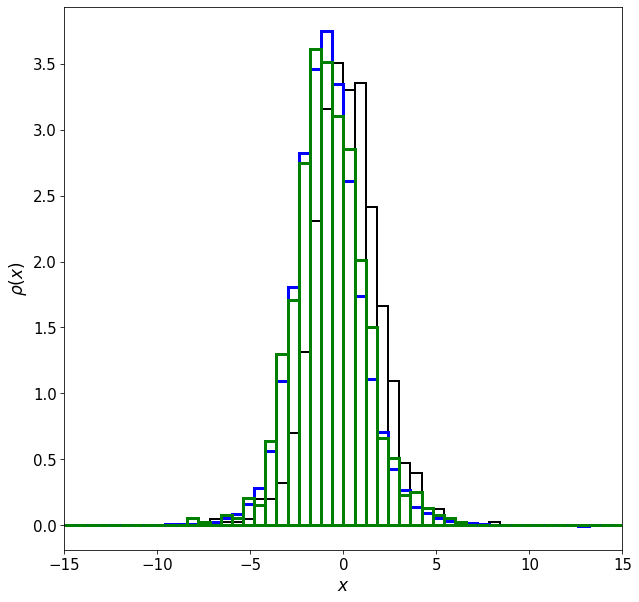

In [54]:
fig, ax= subplots()

ax.bar(bins, input_array[0, :], width=width, lw=2., ec='k', fill=False, align='edge')
ax.bar(bins, output_array[0, :], width=width, lw=3., ec='b', fill=False, align='edge')
ax.bar(bins, target_array[0, :], width=width, lw=3., ec='g', fill=False, align='edge')
ax.set_xlim(x_min, x_max)
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$\rho(x)$')
# ax.set_yscale('log')

In [49]:
# '''
# STEP 8: SAVE THE DATA
# '''
# output_array = np.empty((0, output_dim))
# target_array = np.empty((0, output_dim))
# # Iterate through test dataset
# for inputs, true_outputs in test_loader:
#     inputs = Variable(inputs)
    
#     # Forward pass only to get logits/output
#     model_outputs = model(inputs)

#     loss = criterion(model_outputs, true_outputs)
    
#     npoutputs = model_outputs.detach().numpy()
#     output_array = np.concatenate((output_array, npoutputs))

#     nptargets = true_outputs.detach().numpy()
#     target_array = np.concatenate((target_array, nptargets))

# output_array
# np.save('pert_sech2_test_outputs', output_array)

# target_array
# np.save('pert_sech2_test_targets', target_array)